<a href="https://colab.research.google.com/github/pswaruppk/GL_CAPSTONE/blob/master/pneumonia_option2_mobilenet_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MobileNet-Unet
  This notebook is trying to build unet architecture using Mobilenet as base model. Here we are going to detect each pixel label. Once each pixel type is known, it will extract out the patches of rectanular area having pneumonia label & compare the predicted patches against ground truth bounding box using IOU. 
  This is an encoder-decoder with skip connection based UNET model. 

![UNET](https://raw.githubusercontent.com/pswaruppk/GL_CAPSTONE/master/data/UNET.PNG)

  Mobilenet used here as encoder.This model is proposed by Google which is optimized for having a small model size and faster inference time. This is ideal to run on mobile phones and resource-constrained devices. Due to the small size, there could be a small hit in the accuracy of the model.

  Encoder  produce a low-resolution tensor containing the high-level information.Taking the low-resolution spatial tensor, which contains high-level information, we have to produce high-resolution/same size as input image output. To do that we add more convolution layers coupled with upsampling layers which increase the size of the spatial tensor. As we increase the resolution, we decrease the number of channels as we are getting back to the low-level information.

**Skip connections:**
If we simply stack the encoder and decoder layers, there could be loss of low-level information. Hence, the boundaries in segmentation maps produced by the decoder could be inaccurate.

To make up for the information lost, we let the decoder access the low-level features produced by the encoder layers. That is accomplished by skip connections. Intermediate outputs of the encoder are added/concatenated with the inputs to the intermediate layers of the decoder at appropriate positions.

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_path = "/content/drive/My Drive/rsna-pneumonia-detection-challenge"
os.chdir(project_path)
os.getcwd()

'/content/drive/My Drive/rsna-pneumonia-detection-challenge'

## Model Parameters

In [ ]:
#Set global parameters here
BASE_MODEL = "MobileNet"
MODEL_NAME  = "Option-2" + "." + BASE_MODEL
if os.path.isdir(MODEL_NAME) == False:
  os.mkdir(MODEL_NAME)
WEIGHTS_FILE = MODEL_NAME+"/" + "weights.best.h5"
HISTORY_FILE = MODEL_NAME+"/" +"history.csv"
BATCH_SIZE = 8
IMAGE_SIZE = 224 #target image width
IMG_WIDTH = 1024 #Original image width
FORCE_TRAINING = False #True , change it to force training

ALPHA = 1.0
EPOCHS = 5 

In [ ]:
#Load Utility functions
oldPath = os.getcwd()
utility_path = "/content/drive/My Drive/GL_CAPSTONE"
os.chdir(utility_path)
%run pneumonia_utility.ipynb
baseModel,preprocess_input = selectBaseModel(BASE_MODEL)
os.chdir(oldPath)
print(os.getcwd())
print(baseModel,preprocess_input)

Loading functions from Pneumonia utility notebook
Loading pydicom package
Setting baseModel : MobileNet
<module 'tensorflow.keras.applications.mobilenet' from '/usr/local/lib/python3.6/dist-packages/tensorflow/keras/applications/mobilenet/__init__.py'>
global BaseModel; BaseModel =np.MobileNet
global preprocess_input; preprocess_input =np.preprocess_input
<class 'function'>
/content/drive/My Drive/rsna-pneumonia-detection-challenge
<function MobileNet at 0x7fbf148cf7b8> <function preprocess_input at 0x7fbf148cf950>


In [ ]:
baseModel,preprocess_input

(<function tensorflow.python.keras.applications.mobilenet.MobileNet>,
 <function tensorflow.python.keras.applications.mobilenet.preprocess_input>)

In [ ]:
#Loading full data
full_df,bbox_map,class_enc = loadData()

Loading full CXR info
Loading bbox map


In [ ]:
full_df.head()

,Unnamed: 0,patientId,x,y,width,height,Target,BboxNo,PatientAge,PatientSex,ViewPosition,class,class_id,class_vector,path
0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,51,0,0,No Lung Opacity / Not Normal,1,"[0.0, 1.0, 0.0]",stage_2_train_images/0004cfab-14fd-4e49-80ba-6...
1,1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,48,0,0,No Lung Opacity / Not Normal,1,"[0.0, 1.0, 0.0]",stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c...
2,2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,19,1,1,No Lung Opacity / Not Normal,1,"[0.0, 1.0, 0.0]",stage_2_train_images/00322d4d-1c29-4943-afc9-b...
3,3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,28,1,0,Normal,2,"[0.0, 0.0, 1.0]",stage_2_train_images/003d8fa0-6bf1-40ed-b54c-a...
4,4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,32,0,1,Lung Opacity,0,"[1.0, 0.0, 0.0]",stage_2_train_images/00436515-870c-4b36-a041-d...


In [ ]:
full_df.drop(full_df.columns[0],inplace=True,axis=1)

In [ ]:
bbox_map['000db696-cf54-4385-b10b-6b16fbb3f985']

{'bboxes': [[318, 316, 478, 170], [375, 660, 402, 146]],
 'path': 'stage_2_train_images/000db696-cf54-4385-b10b-6b16fbb3f985.dcm'}

In [ ]:
full_df[full_df.patientId == '000db696-cf54-4385-b10b-6b16fbb3f985']

,patientId,x,y,width,height,Target,BboxNo,PatientAge,PatientSex,ViewPosition,class,class_id,class_vector,path
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,2,25,0,1,Lung Opacity,0,"[1.0, 0.0, 0.0]",stage_2_train_images/000db696-cf54-4385-b10b-6...
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,2,25,0,1,Lung Opacity,0,"[1.0, 0.0, 0.0]",stage_2_train_images/000db696-cf54-4385-b10b-6...


In [ ]:
pd_label = pd.read_csv('stage_2_train_labels.csv')
pd_label[pd_label.patientId == '000db696-cf54-4385-b10b-6b16fbb3f985']

,patientId,x,y,width,height,Target
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1


In [ ]:
print('{}:Total Pneumonia Patient'.format(len(full_df[full_df.Target == 1])))

9555:Total Pneumonia Patient


In [ ]:
#Split the dataset  into 3 train/valid/test
unbalanced_train_df, valid_df, test_df = splitData(full_df)

(18678, 14) training data
(8006, 14) raw validation data
(4003, 14) Validation data
(4003, 14) test data


In [ ]:
unbalanced_train_df[unbalanced_train_df.Target == 1].shape[0]

4208

8416 Final training size


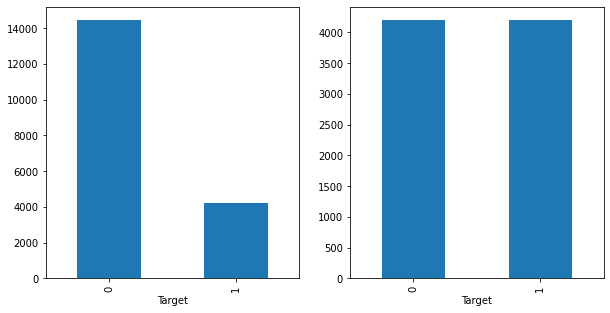

In [ ]:
import matplotlib.pyplot as plt
TRAIN_SAMPLES = 8416
#Balancing training set
train_df = balance_df(unbalanced_train_df,TRAIN_SAMPLES)
print(train_df.shape[0], 'Final training size')

In [ ]:
def build_mobile_UNetModel():
    model = BaseModel(input_shape =(IMAGE_SIZE, IMAGE_SIZE, 3),include_top = False,alpha=ALPHA, weights = 'imagenet')
    # model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA, weights="imagenet") 
    model.trainable = False
    for layer in model.layers:
        layer.trainable = False

   
    convLayer_112by112 = model.get_layer("conv_pw_1_relu").output
    convLayer_56by56 = model.get_layer("conv_pw_3_relu").output
    convLayer_28by28 = model.get_layer("conv_pw_5_relu").output
    convLayer_14by14 = model.get_layer("conv_pw_11_relu").output
    convLayer_7by7 = model.get_layer("conv_pw_13_relu").output
    
    x = Concatenate()([UpSampling2D()(convLayer_7by7), convLayer_14by14])
    x = Concatenate()([UpSampling2D()(x), convLayer_28by28])
    x = Concatenate()([UpSampling2D()(x), convLayer_56by56])
    x = Concatenate()([UpSampling2D()(x), convLayer_112by112])
    x = UpSampling2D(name="unet_last")(x) # upsample to 224x224

    # Add classification layer
    x = Conv2D(1, kernel_size=1, activation="sigmoid", name="masks")(x)
    x = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x) 

    return Model(inputs=model.input, outputs=x)

In [ ]:
len(np.unique(train_df["path"].to_numpy()))

8416

In [ ]:
# BATCH_SIZE = 8
# IMAGE_SIZE = 224
# IMG_WIDTH = 1024
train_gen = MyDataGenerator(train_df)
valid_gen = MyDataGenerator(valid_df)

print(len(train_gen), "# of iterations in one train epoch")
print(len(valid_gen), "# of iterations in one validate epoch")

8416 :No of generator Image
4003 :No of generator Image
1052 # of iterations in one train epoch
500 # of iterations in one validate epoch


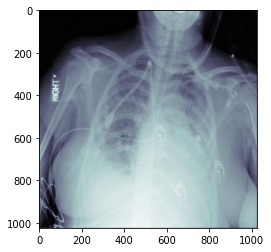

In [ ]:
# path = bbox_map['000db696-cf54-4385-b10b-6b16fbb3f985'].get('path')
# img = train_gen.getImage(path)
# plt.imshow(img, cmap=plt.cm.bone)

In [ ]:
Set = 870
imageSet = train_gen[Set][0]
maskSet = train_gen[Set][1]   

In [ ]:
imageSet.shape,maskSet.shape

((8, 224, 224, 3), (8, 224, 224))

In [ ]:
SetIndex = 0
imageIndex = Set*BATCH_SIZE + SetIndex
path = train_gen.filenames[imageIndex]
img = train_gen.getImage(path)

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(img, cmap=plt.cm.bone)
ax[0].set_title("Original Xray")
ax[1].imshow(imageSet[SetIndex][:,:,0],cmap=plt.cm.bone)
ax[1].set_title("Mask")
# The images are converted from RGB to BGR, 
#then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.

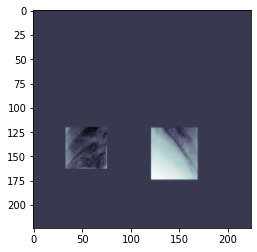

In [ ]:
showMaskedImage(imageSet,maskSet,1)

## Build model

In [ ]:
#Add optimizar,check point & early stopping 
#Initial learning rate 0.0001, try other 0.001 & default beta-1 & 2
lr = 1e-4
decay = lr/EPOCHS # or in the factor of 10
adamOptimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay, amsgrad=False)
checkpoint = ModelCheckpoint(WEIGHTS_FILE, monitor="val_loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min")
stop = EarlyStopping( monitor="val_loss", patience=2, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6, verbose=1, mode="min")

mobile_unet_Model = build_mobile_UNetModel()
mobile_unet_Model.compile(loss=iou_loss, optimizer=adamOptimizer, metrics=[mean_iou]) 

17227776/17225924 [==============================] - 0s 0us/step


##Model Fit

In [ ]:

history = pd.DataFrame()

if (os.path.isfile(WEIGHTS_FILE) & (FORCE_TRAINING == False) ):
  mobile_unet_Model.load_weights(WEIGHTS_FILE)
  history = loadHistory(HISTORY_FILE)
else:
  if (os.path.isfile(WEIGHTS_FILE)):
    mobile_unet_Model.load_weights(WEIGHTS_FILE)
  history = mobile_unet_Model.fit(train_gen,   # (X_train, y_train)
                        epochs=EPOCHS,
                        validation_data=valid_gen,#(X_valid, y_valid)
                        callbacks=[checkpoint, reduce_lr, stop],
                        shuffle=True,
                        verbose=1)
  
  history = saveHistory(history,HISTORY_FILE)

## History

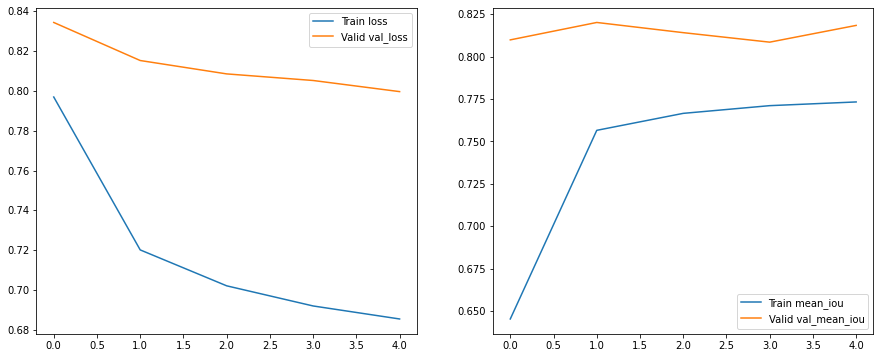

In [ ]:
plot_his(history)

## Predict sample image

In [ ]:
imageSet = valid_gen[9][0]
maskSet = valid_gen[9][1]
predMaskSet = mobile_unet_Model.predict(imageSet)


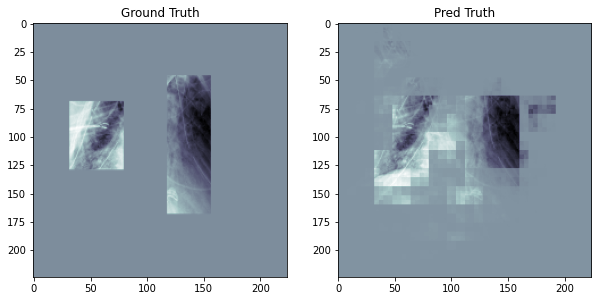

In [ ]:
loc = 3
showMaskedImage(imageSet,maskSet,loc,predMaskSet)

**Red** Bounding box: **PREDICTED**
**Blue** bouding box: **TRUTH**


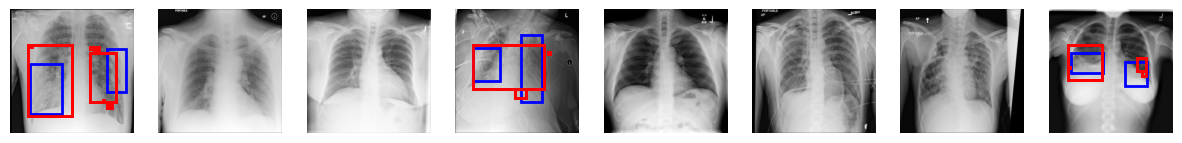

In [ ]:
#Show prediction on sample batch
showPredMaskedBatch(imageSet,maskSet,predMaskSet)

## Predict on test data set

In [ ]:
iou = 0.3
no_test = test_df.shape[0]
pred_file = MODEL_NAME + '/prediction.' +str(iou)+ str(no_test) +'.csv'
FORCE_PREDICTION = False;
pred_test_df = pd.DataFrame()
pred_test_df = 0
test_y = 0;
pred_y = 0
if ((os.path.isfile(pred_file) == False) | (FORCE_PREDICTION)):
  print('Predicting on test dataframe')
  #Pass test dataframe, bouding box map, trained mode, file to dump prediction, IoU threshold
  pred_test_df,test_y,pred_y = doMaskPrediction(test_df,bbox_map,mobile_unet_Model,pred_file,iou)
else:
  pred_test_df = pd.read_csv(pred_file)
  test_y = pred_test_df["Target"]
  pred_y = pred_test_df["predTarget"]
 
 

In [ ]:
len(set(pred_test_df[pred_test_df.predTarget == 1].patientId))

345

In [ ]:
len(set(pred_test_df[pred_test_df.Target == 1].patientId))

901

##Show top IOU prediction

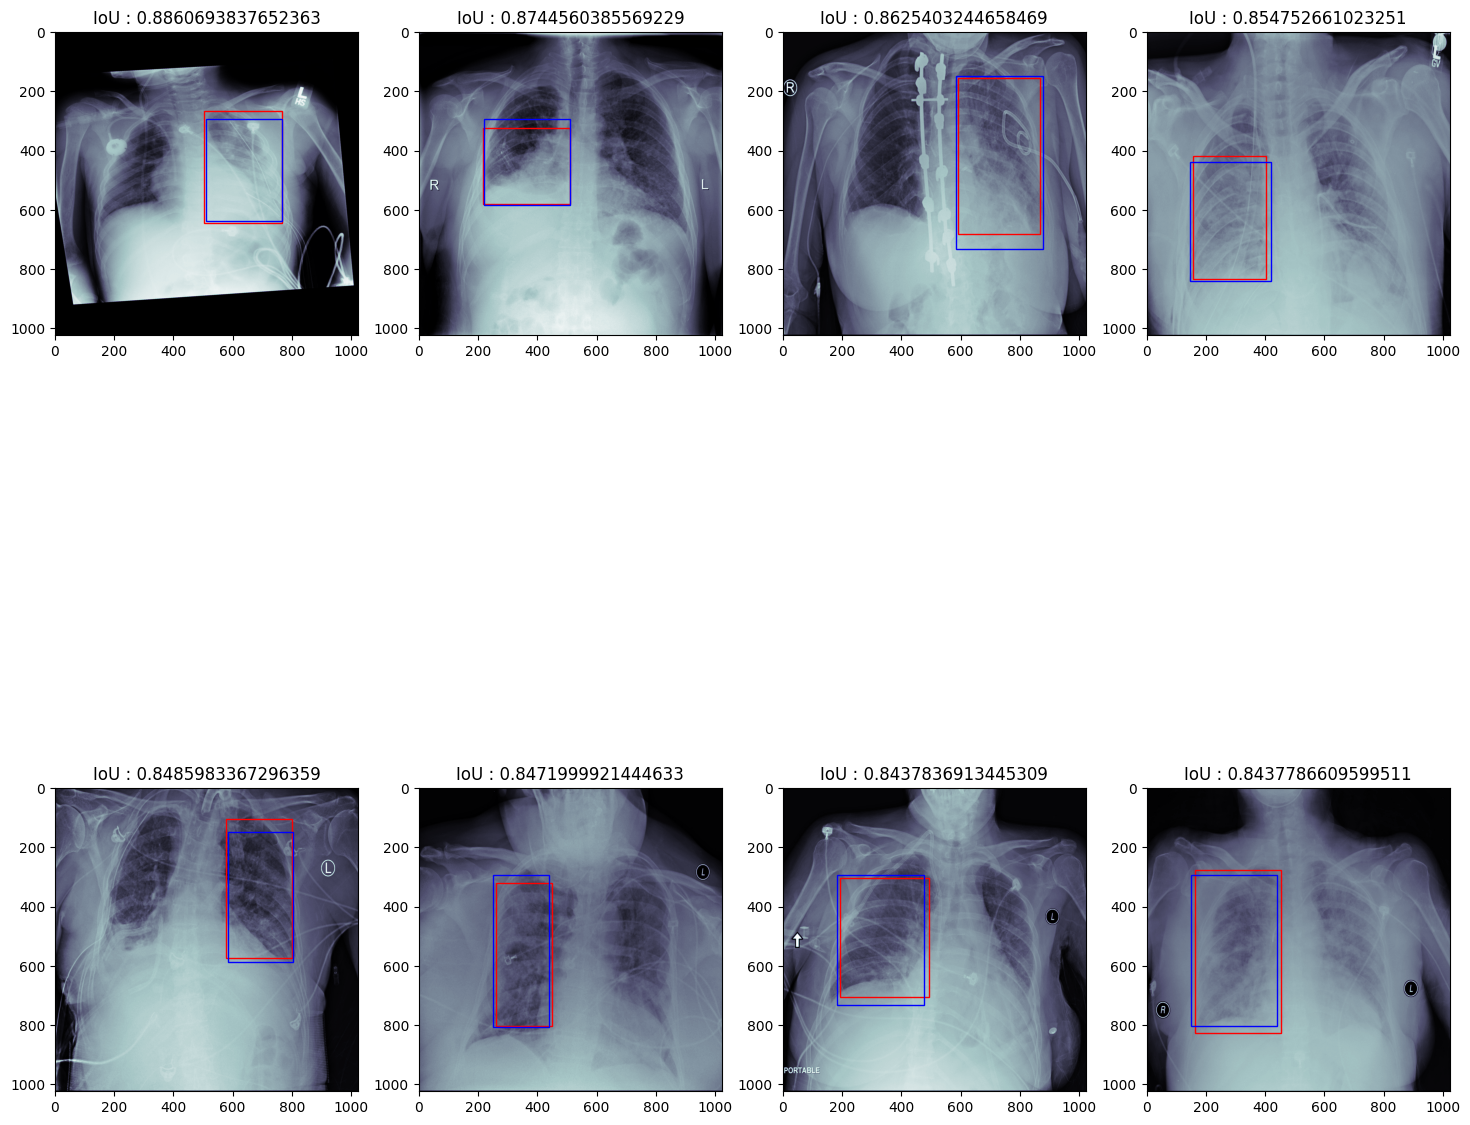

In [ ]:
# pred_test_df = pd.read_csv(pred_file)
topNo = 8
show_top_prediction(pred_test_df,topNo)

## Performance(Recall)

In [ ]:
print("Confusion Matrix:- \n", metrics.confusion_matrix(test_y, pred_y), "\n")
print("Classification Report:- \n", metrics.classification_report(test_y, pred_y))

Confusion Matrix:- 
 [[3099    0]
 [1104  358]] 

Classification Report:- 
               precision    recall  f1-score   support

           0       0.74      1.00      0.85      3099
           1       1.00      0.24      0.39      1462

    accuracy                           0.76      4561
   macro avg       0.87      0.62      0.62      4561
weighted avg       0.82      0.76      0.70      4561



### Confidence score

## Conclusion